In [1]:
input_dim = 13
model_file = "Model/model.cpkt"
num_clusters = 4

import json
import matplotlib.pyplot as plt
from matplotlib.path import Path
import numpy as np
import os
import pandas as pd
import scipy
import tensorflow as tf

import sys
sys.path.insert(0, "../Code/")
from base import load_encoder
from explain_sync import explain, apply

from data import load_data

def load_model(input_dim = input_dim, model_file = model_file):
    return load_encoder(input_dim, model_file)


In [2]:
###
# Load Data & Configuration
###

x, y = load_data()

with open("vertices.json") as json_file:  
    all_vertices = json.load(json_file)


INFO:tensorflow:Restoring parameters from Model/model.cpkt


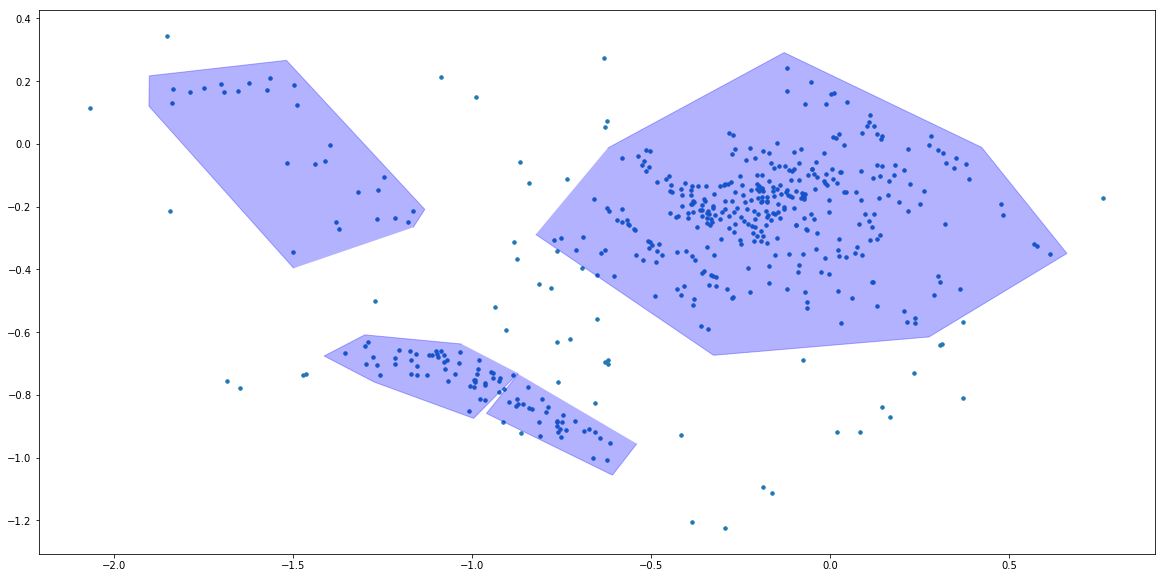

In [3]:
###
# Visualize the data and the marked clusters
###

sess, rep, X, D = load_model()

data_rep = sess.run(rep, feed_dict={X: x, D: np.zeros((1, input_dim))})

fig, ax = plt.subplots(figsize=(20, 10))
patches = []

for i in range(num_clusters):
    line = plt.Polygon(all_vertices[i], closed=False, color="blue", alpha=0.3)
    ax.add_line(line)

plt.scatter(data_rep[:, 0], data_rep[:, 1], s = 12)

plt.show()
plt.close()

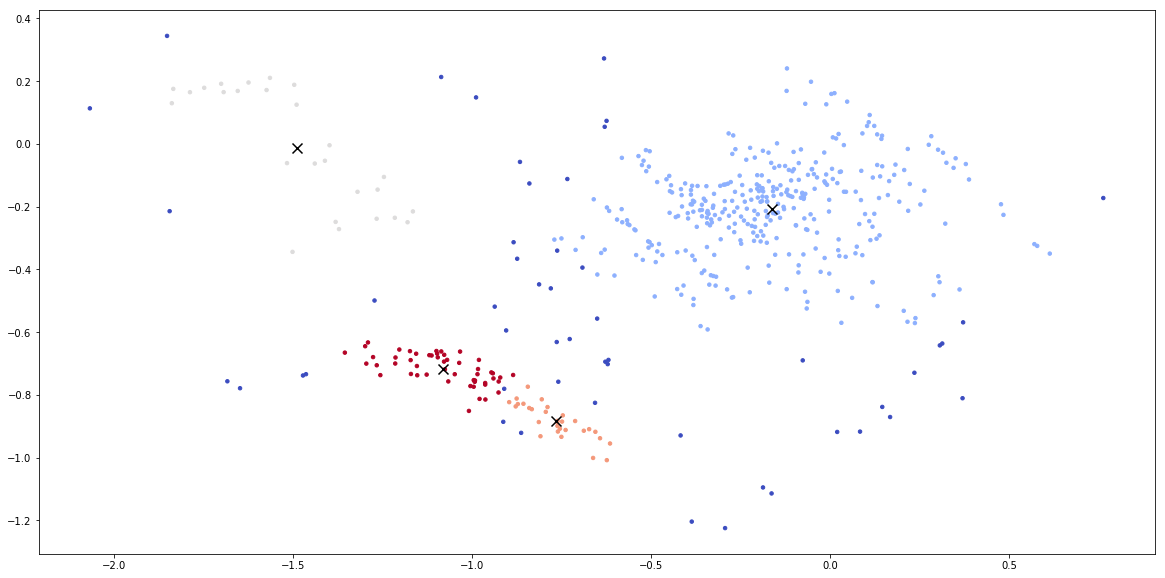

In [4]:
###
# Find the datapoints in each marked cluster
###

m = data_rep.shape[0]
cluster = -1.0 * np.ones((m))
indices = [[]] * num_clusters
centers = [[]] * num_clusters
for i in range(num_clusters):
    path = Path(all_vertices[i])
    indices[i] = []
    for j in range(m):
        if path.contains_points(data_rep[j].reshape((1,2))):
            cluster[j] = i
            indices[i].append(j)
    centers[i] = np.mean(data_rep[indices[i], :], axis = 0)
    
centers = np.array(centers)

fig, ax = plt.subplots(figsize=(20, 10))
patches = []
    
plt.scatter(data_rep[:, 0], data_rep[:, 1], s = 12, c = cluster, cmap = plt.cm.coolwarm)
plt.scatter(centers[:, 0], centers[:, 1], c = "black", marker = "x", s = 100)

plt.show()
plt.close()   

In [5]:
###
# Compute the cluster explanations
###

lambda_init = 0.25
factor = 1.1
threshold = 0.1

while True:
    os.system("rm -rf explanation")
    deltas, score = explain(load_model, x, data_rep, indices, dispersion = 0.0, lambda_global = lambda_init, num_points = 10, learning_rate = 0.01)    
    print(lambda_init, score)
    
    if score > threshold:
        break
    else:
        lambda_init *= factor


INFO:tensorflow:Restoring parameters from Model/model.cpkt
0 1.0791566
1 0.9766491867601871
13 0.8903348726576654
28 0.8339182903866129
29 0.7572879288047693
30 0.6912131571874148
31 0.6750179526899869
32 0.6212846396292402
33 0.5787937201194602
34 0.5286670273959014
35 0.48084620913142323
36 0.44758784425503934
37 0.41268664734584326
38 0.3763918799491725
60 0.34664522239320233
61 0.31566934700685223
62 0.30040965750107895
63 0.2763470435824072
156 0.26714189232123053
183 0.26269827413376184
184 0.24280894065930853
204 0.22789603069515993
233 0.2186838955159724
234 0.20863755081377092
235 0.19672239080919324
239 0.18502184175715328
246 0.18284620099755644
247 0.17023086550974117
248 0.16542646589705287
335 0.16110756779313237
336 0.15124098205208913
337 0.14294561365521077
409 0.1322973865447767
412 0.12400127241233992
421 0.1190585630954062
422 0.10993260073549346
989 0.10423622954505635
992 0.10156020023388156
996 0.09819371230466355
1259 0.09474760631212988
INFO:tensorflow:Restorin

593 0.14655857965379293
658 0.14322747820942464
1007 0.13793650437797378
1166 0.13556789683390272
1167 0.13347368532796453
1207 0.12629879595324017
INFO:tensorflow:Restoring parameters from Model/model.cpkt
0.44289025000000026 0.09906789
INFO:tensorflow:Restoring parameters from Model/model.cpkt
0 0.87013817
1 0.7978274449706078
2 0.7544729463756084
12 0.7127989099003983
15 0.6828093432144765
17 0.6181991352123737
25 0.5980595102024687
31 0.5749278545390961
32 0.5580740612755476
33 0.5060684532234304
34 0.4779643401780039
35 0.43406916427120357
48 0.43143609758310864
75 0.42799457648115435
88 0.39879551457831136
89 0.36148844166072197
93 0.32874855850813756
94 0.307653677058321
152 0.2809287511405839
233 0.2671599043696084
234 0.25343340664705266
237 0.24170113674381238
238 0.22965370331626112
327 0.21496933014022376
328 0.19918016361439586
330 0.1837209435449832
342 0.1821001462843283
429 0.18088815549246284
430 0.16602835004834962
431 0.15556707109786838
432 0.15046272539297734
434 0


From  0  to  1 

INFO:tensorflow:Restoring parameters from Model/model.cpkt


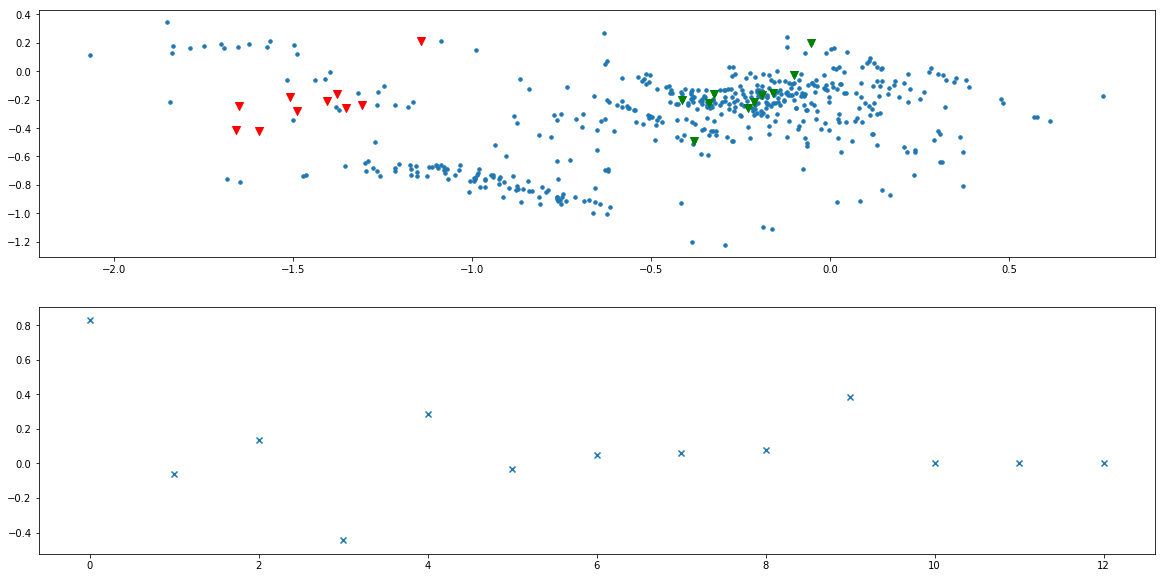


From  1  to  0 

INFO:tensorflow:Restoring parameters from Model/model.cpkt


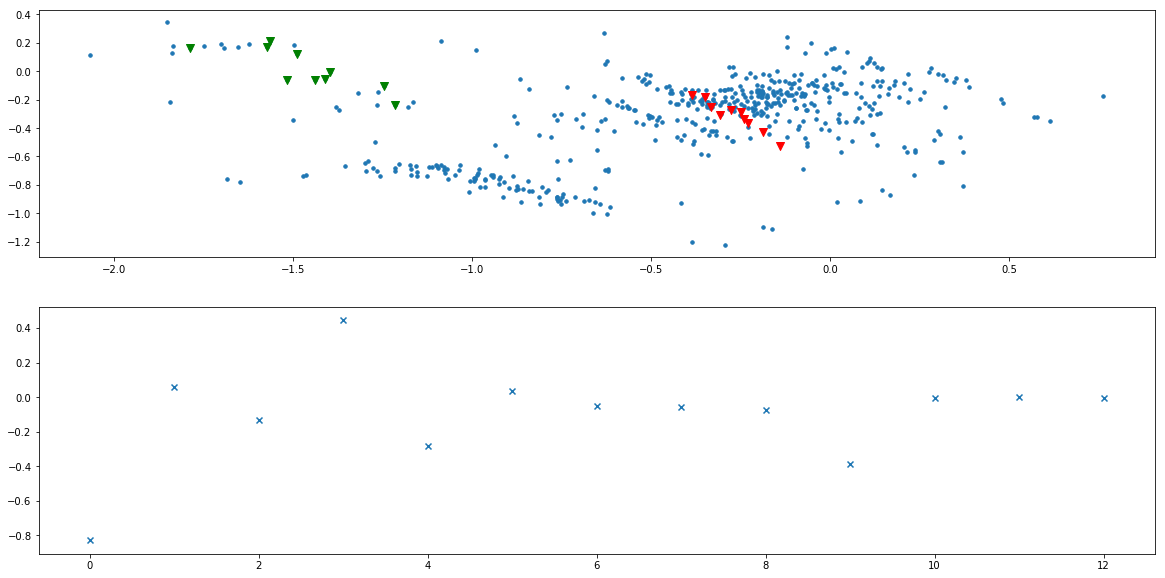


From  0  to  2 

INFO:tensorflow:Restoring parameters from Model/model.cpkt


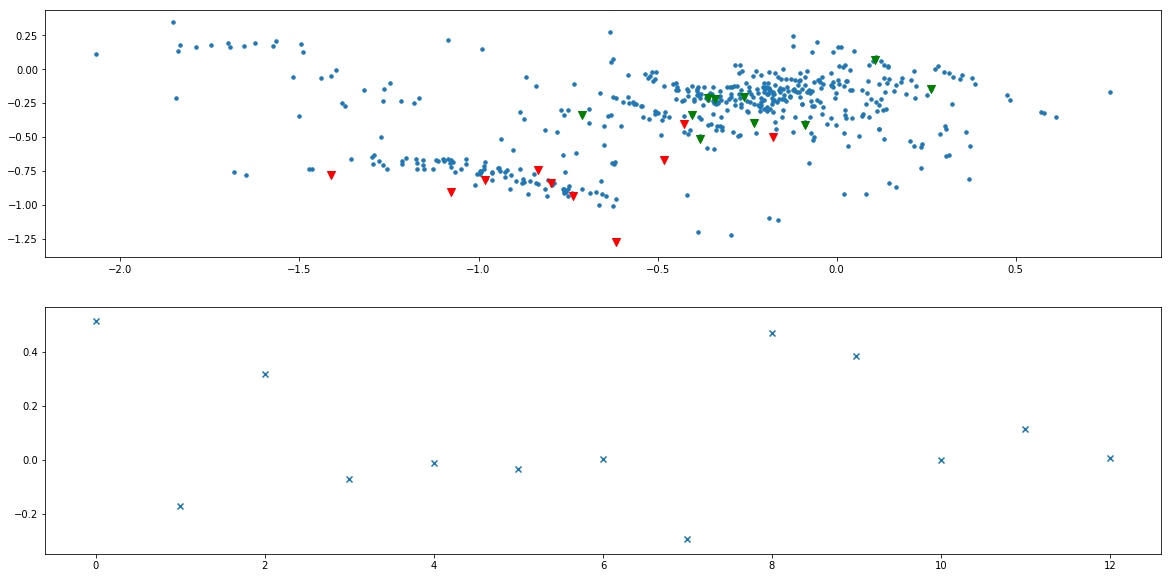


From  2  to  0 

INFO:tensorflow:Restoring parameters from Model/model.cpkt


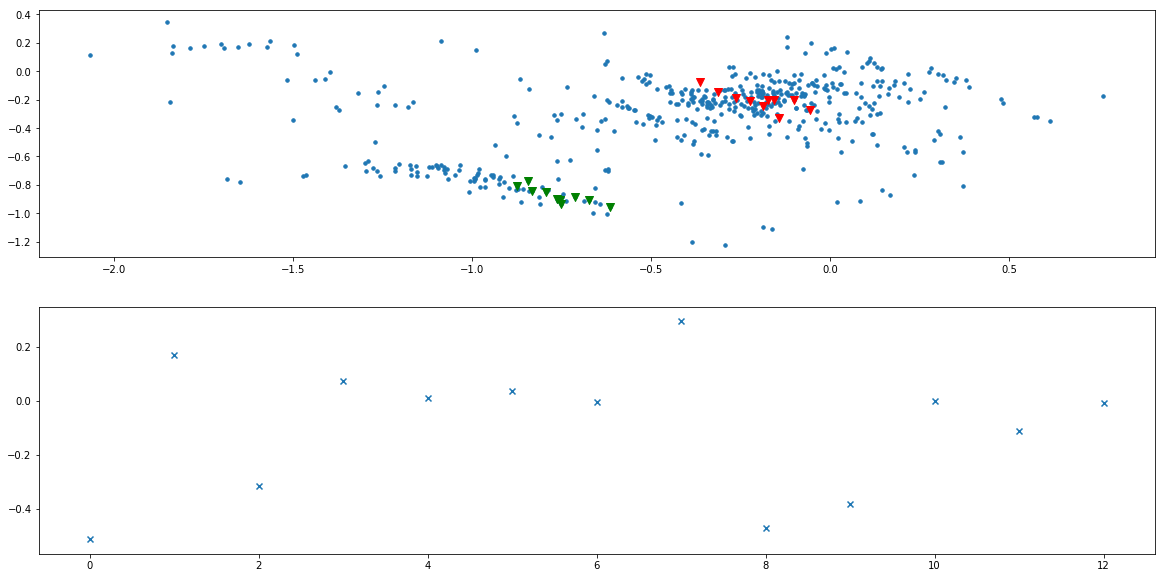


From  2  to  3 

INFO:tensorflow:Restoring parameters from Model/model.cpkt


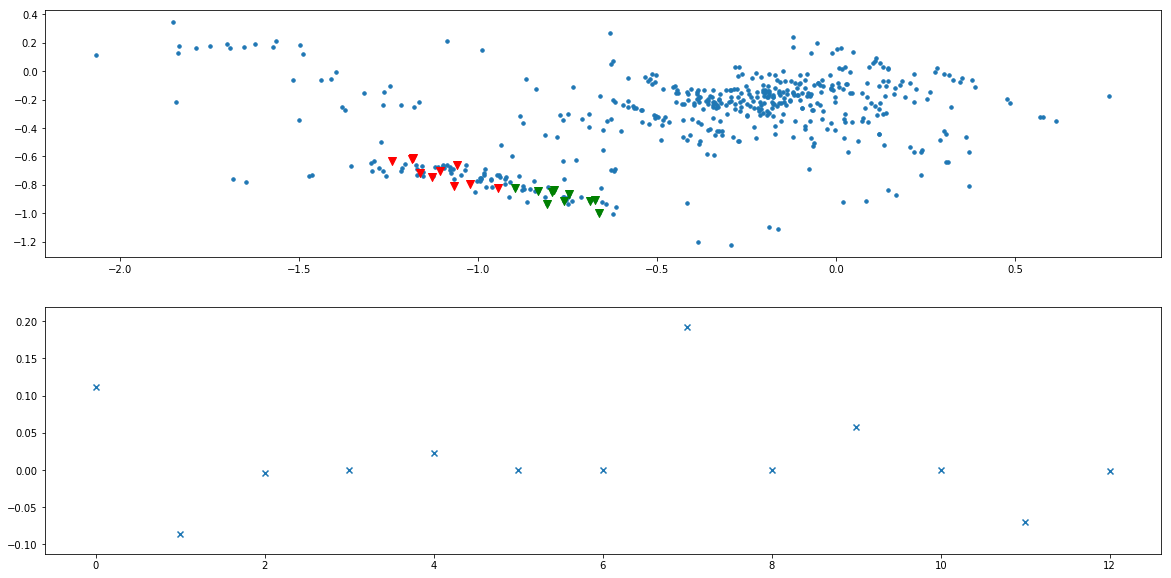


From  3  to  2 

INFO:tensorflow:Restoring parameters from Model/model.cpkt


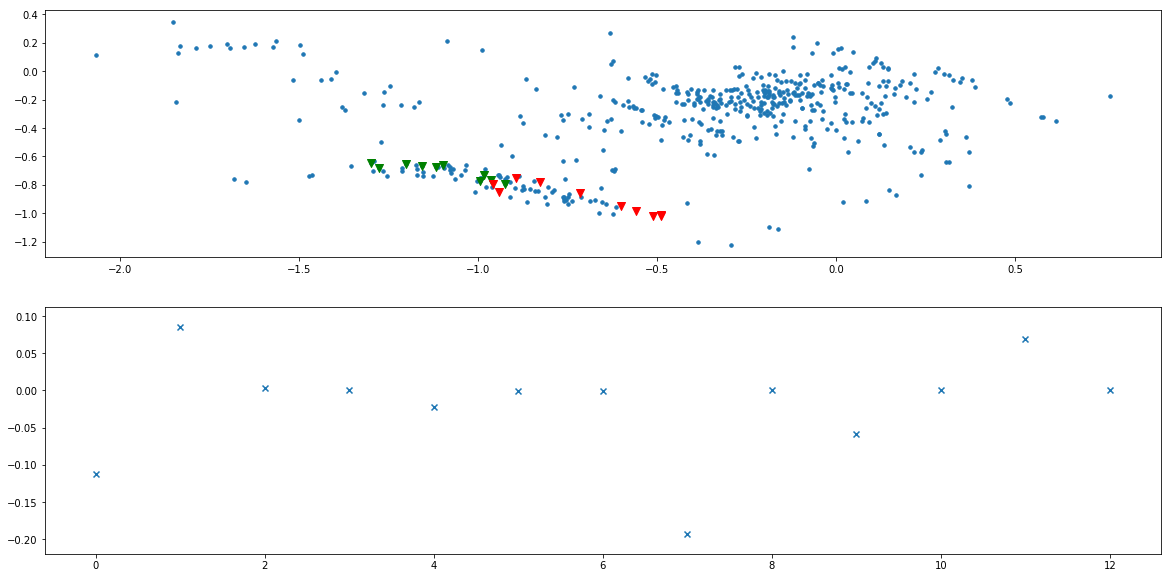

In [6]:
###
# Visualize the cluster explanations
###

def myplot(c1, c2):
    print("\nFrom ", c1, " to ", c2, "\n")
    
    if c1 == 0:
        d = deltas[c2 - 1]
    elif c2 == 0:
        d = -1.0 * deltas[c1 - 1]
    else:
        d = -1.0 * deltas[c1 - 1] + deltas[c2 - 1]
        
    apply(load_model, x, data_rep, indices, c1, np.reshape(d, (1, input_dim)), num_points = 10)
    
myplot(0, 1)
myplot(1, 0)
myplot(0, 2)
myplot(2, 0)

myplot(2, 3)
myplot(3, 2)
